# 04. Classification

A classification problem involves predicting whether something is one thing or another.

For example, you want to:

| Problem Type               | What is it?                              | Example                                                 |
| -------------------------- | ---------------------------------------- | ------------------------------------------------------- |
| Binary Classification      | Predict one of two classes               | Is this email spam or not?                              |
| Multi-class Classification | Predict one of multiple classes          | Predict whether a photo is a dog, cat, or rabbit.       |
| Multi-label Classification | Predict multiple classes for each sample | Predict whether a photo contains a dog, cat, or rabbit. |


## Prepare Data

For this example, we'll use the `make_circles` dataset from `sklearn.datasets` to generate two circles with different colored dots.


In [1]:
from sklearn.datasets import make_circles
import pandas as pd

n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


Looking at the data, we can see that it has two features (X1 and X2) and a label (0 or 1) indicating which circle the point belongs to.

This means that our problem is a \***\*binary classification problem\*\***, where we want to predict whether a point belongs to the inner circle (label 0) or the outer circle (label 1).


In [2]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

The cell above shows us that there are 500 points in each class, which is a balanced dataset.

Let's visualize the data to see what it looks like.


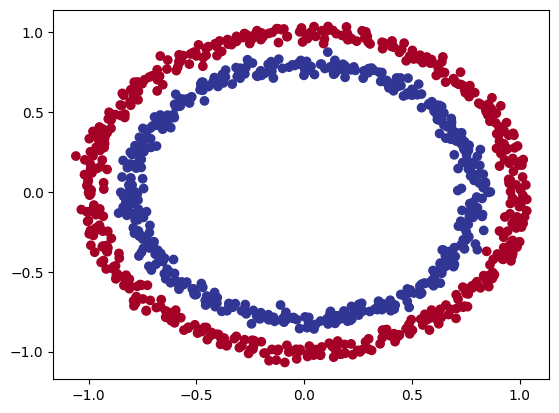

In [3]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

We should notice right away that the data is not linearly separable, meaning we cannot draw a straight line to separate the two classes. This is a hint for later when we choose our model architecture, as we will need a model that can handle non-linear relationships.

First we will use a linear model, then we will use a non-linear model to see the difference in performance and really understand the power of non-linear models.


### Input and Output Shapes

As mentioned earlier, one of the most common errors in deep learning is shape errors. Which is why it is very important to spend time exploring the data and understanding the input and output shapes.

Let's take a look at the input and output shapes of our dataset.


In [4]:
print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")

Input shape: (1000, 2)
Output shape: (1000,)


What does this mean?

The input shape is `(1000, 2)`, which means we have 1000 samples and each sample has 2 features (X1 and X2).
The output shape is `(1000,)`, which means we have 1000 labels, one for each sample.

We have two inputs for one output.

### Data To Tensors and Create Training and Test Split

Now that we have our data, we need to convert it to PyTorch tensors and create a training and test split.
We will use 80% of the data for training and 20% for testing.


In [5]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

Now let's split the data into training and test sets.

There are many ways to do this, but we will use the `train_test_split` function from `sklearn.model_selection`.

This is a good method because it randomly splits the data into training and test sets, which is important for avoiding bias in the model.


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training Features Length: {len(X_train)}")
print(f"Test Features Length: {len(X_test)}")

Training Features Length: 800
Test Features Length: 200


## Build Model


In [7]:
import torch
from torch import nn

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


Now `device` is setup to use GPU if available, otherwise it will use CPU. This is important for training models on larger datasets or more complex models.

Let's build our model.


In [8]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

`self.layer_1` takes 2 input features and produces. 5 output features. This is known as having 5 **hidden units** or **neurons**.

The number of hidden units is a hyperparameter that we can tune later to see if it improves our model's performance.

`self.layer_2` takes the 5 output features from `layer_1` and produces 1 output feature. This is our final output layer, which will give us the predicted class (0 or 1).

In order to visualize this better, try creating a neural network on the [TensorFlow Playground](https://playground.tensorflow.org/). I would recommend spending some time playing around with the different hyperparameters and seeing how they affect the model's performance.

You can change:

- The number of hidden units
- The number of hidden layers
- The activation function (first use `linear`, then try `relu` or `sigmoid`)
- Add noise to the data
- Batch size

One of the things you want to do when you have a model, is just pass some data through it to see if it works as expected. This is called a **forward pass**.


In [9]:
untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test labels: {len(y_test)}, Shape: {y_test.shape}")

print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test labels: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.7936],
        [-0.8345],
        [-0.3939],
        [-0.9080],
        [ 0.0704],
        [ 0.0418],
        [-0.4413],
        [-0.2349],
        [-0.4141],
        [-0.8321]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


As you notice, the predictions are not in the same form or shape as our test labels. We will explore how to fix this later on.

### Loss Function and Optimizer

As mentioned in [the previous notebook](03_linear_regression.ipynb), different loss functions are used for different tasks. For binary classification tasks like ours, we typically use [binary cross-entropy loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a/).

The same optimizer can be used across different problems.

| Loss Function                    | Problem Type                                              | Explanation Link                                                                                                                       |
| -------------------------------- | --------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| Binary Cross Entropy (BCE)       | Binary classification                                     | [Understanding BCELoss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a/) |
| BCE with Logits                  | Binary classification (with improved numerical stability) | [BCEWithLogitsLoss — PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)                               |
| Cross Entropy                    | Multi-class classification                                | [CrossEntropyLoss — PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)                                 |
| Categorical Cross Entropy        | Multi-class classification (one-hot encoded labels)       | [Keras CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)                       |
| Sparse Categorical Cross Entropy | Multi-class classification (integer labels)               | [Keras SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class)           |
| Mean Squared Error (MSE)         | Regression, less focus on outliers                        | [MSELoss — PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)                                                   |
| Mean Absolute Error (MAE)        | Regression, more robust to outliers                       | [L1Loss — PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)                                                     |
| Huber Loss                       | Regression, combines MSE and MAE                          | [SmoothL1Loss — PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html)                                         |
| KL Divergence                    | Comparing probability distributions                       | [KLDivLoss — PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html)                                               |
| Hinge Loss                       | Binary classification (SVMs)                              | [Hinge Loss — Wikipedia](https://en.wikipedia.org/wiki/Hinge_loss)                                                                     |
| Triplet Loss                     | Similarity learning, facial recognition                   | [TripletMarginLoss — PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html)                               |
| Focal Loss                       | Classification with class imbalance                       | [Focal Loss — Paper](https://arxiv.org/abs/1708.02002) / [Implementation](https://github.com/AdeelMufti/Focal-Loss-PyTorch)            |
| Cosine Similarity Loss           | Directional data or embeddings                            | [CosineEmbeddingLoss — PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.CosineEmbeddingLoss.html)                           |
| CTC Loss                         | Sequence prediction (e.g., speech recognition)            | [CTCLoss — PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html)                                                   |
| Dice Loss                        | Image segmentation                                        | [Dice Loss — MONAI](https://docs.monai.io/en/stable/losses.html#diceloss)                                                              |
| IoU Loss                         | Object detection and segmentation                         | [IoU Loss — Paper](https://arxiv.org/abs/1902.09630) / [Implementation](https://github.com/JunMa11/SegLoss/tree/master/losses_pytorch) |

PyTorch has two binary cross entropy loss functions:

1. `torch.nn.BCELossWithLogits`: This combines a sigmoid layer and the binary cross-entropy loss in one single class. It is more numerically stable than using a plain Sigmoid followed by a BCELoss.
2. `torch.nn.BCELoss`: This expects the input to be probabilities (between 0 and 1) and the target to be the same. It is less numerically stable than `BCELossWithLogits`.

> Note: Here is a [discussion on the PyTorch forum regarding `BCELoss` and `BCELossWithLogits`](https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4)


In [10]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

We will create an **evaluation metric**, which offers another perspective on how well our model is performing.

If a loss function measures how _wrong_ our model is, an evaluation metric measures how _right_ our model is.

Here are some common evaluation metrics for classification problems:

| Metric                           | Description                                            | When to Use                                               | Explanation Link                                                                                                                   |
| -------------------------------- | ------------------------------------------------------ | --------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| Accuracy                         | Ratio of correct predictions to total predictions      | Balanced datasets where all classes are equally important | [Accuracy — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)                   |
| Precision                        | Ratio of true positives to all predicted positives     | When false positives are costly (e.g., spam detection)    | [Precision — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)                 |
| Recall (Sensitivity)             | Ratio of true positives to all actual positives        | When false negatives are costly (e.g., disease detection) | [Recall — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)                       |
| F1 Score                         | Harmonic mean of precision and recall                  | When balance between precision and recall is needed       | [F1 Score — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)                         |
| AUC-ROC                          | Area Under the Receiver Operating Characteristic Curve | Evaluating model's ability to distinguish between classes | [ROC AUC — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)                     |
| Confusion Matrix                 | Table showing TP, FP, TN, FN counts                    | Detailed analysis of model predictions                    | [Confusion Matrix — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)         |
| Specificity                      | Ratio of true negatives to all actual negatives        | When true negative rate is important                      | [Specificity — Wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Specificity)                                   |
| Log Loss                         | Measures certainty of predictions                      | When probabilistic outputs are important                  | [Log Loss — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)                         |
| Matthews Correlation Coefficient | Balanced measure for imbalanced datasets               | Imbalanced binary classification problems                 | [MCC — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)                     |
| Cohen's Kappa                    | Agreement between model and truth beyond chance        | When baseline accuracy is high                            | [Cohen’s Kappa — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html)           |
| Balanced Accuracy                | Average of recall for each class                       | Imbalanced datasets                                       | [Balanced Accuracy — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) |

For our current problem, we will use **accuracy** as our evaluation metric. This is a good starting point for binary classification problems, especially when the classes are balanced.


In [11]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.tensor:
    """
    Calculates accuracy between y_true and y_pred
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Train Model

Below are the training steps we will follow:

1. Forward pass - The model goes through all of the training data once, performing its `forward()` function calculations (`model(x_train)`).

2. Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (`loss = loss_fn(y_pred, y_train)`).
3. Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (`optimizer.zero_grad()`).
4. Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as backpropagation, hence "backwards" (`loss.backward()`).
5. Step the optimizer (gradient descent) - Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them (`optimizer.step()`).

### Raw Outputs -> Prediction Probabilities -> Prediction Labels


In [12]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.7936],
        [-0.8345],
        [-0.3939],
        [-0.9080],
        [ 0.0704]], grad_fn=<SliceBackward0>)

The outputs above are the raw outputs of the model, specifically of the `forward()` function. These raw outputs (unmodified), are often referred to as **[logits](https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean/31045#31045)**.

As we can see, the outputs are quite different from our labels. WE need to convert the raw outputs to probabilities and then to labels.

To convert the raw outputs to probabilities, we can use the `torch.sigmoid()` function. This will apply the sigmoid activation function to each output, transforming them into values between 0 and 1.

So the steps to convert the raw outputs to prediction labels are:

1. Get the raw outputs from the model (logits).
2. Apply the sigmoid activation function to the logits to get probabilities.
3. Convert the probabilities to labels by thresholding (e.g., if probability > 0.5, label is 1, otherwise 0).


In [13]:
# In full, this looks as follows
logits = model_0(X_test.to(device))[:5]
print(f"Logits:\n{logits}\n")

y_pred_probabilities = torch.sigmoid(logits)
print(f"Predicted Probabilities:\n{y_pred_probabilities}\n")

y_pred = torch.round(y_pred_probabilities)
print(f"Predicted Labels:\n{y_pred}\n")

print(f"True Labels:\n{y_test[:5]}\n")

Logits:
tensor([[-0.7936],
        [-0.8345],
        [-0.3939],
        [-0.9080],
        [ 0.0704]], grad_fn=<SliceBackward0>)

Predicted Probabilities:
tensor([[0.3114],
        [0.3027],
        [0.4028],
        [0.2874],
        [0.5176]], grad_fn=<SigmoidBackward0>)

Predicted Labels:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)

True Labels:
tensor([1., 0., 1., 0., 1.])



As we can see, the predictions are now in the same form as our labels. We can now calculate the accuracy of our model by comparing the predictions to the labels.

### Training and Testing Loop


In [14]:
torch.manual_seed(42)

EPOCHS = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
    model_0.train()

    y_logits = model_0(X_train).squeeze()  # Squeeze to remove extra dimension
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        if epoch % 10 == 0:
            print(
                f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"
            )

Epoch: 0 | Loss: 0.72648, Accuracy: 45.25% | Test loss: 0.71556, Test acc: 46.00%
Epoch: 10 | Loss: 0.70509, Accuracy: 47.75% | Test loss: 0.69753, Test acc: 51.50%
Epoch: 20 | Loss: 0.69925, Accuracy: 48.62% | Test loss: 0.69325, Test acc: 49.00%
Epoch: 30 | Loss: 0.69714, Accuracy: 49.75% | Test loss: 0.69213, Test acc: 51.50%
Epoch: 40 | Loss: 0.69607, Accuracy: 50.00% | Test loss: 0.69179, Test acc: 50.50%
Epoch: 50 | Loss: 0.69537, Accuracy: 50.25% | Test loss: 0.69168, Test acc: 51.00%
Epoch: 60 | Loss: 0.69487, Accuracy: 50.12% | Test loss: 0.69168, Test acc: 51.50%
Epoch: 70 | Loss: 0.69450, Accuracy: 49.88% | Test loss: 0.69174, Test acc: 52.00%
Epoch: 80 | Loss: 0.69421, Accuracy: 50.62% | Test loss: 0.69183, Test acc: 52.50%
Epoch: 90 | Loss: 0.69399, Accuracy: 50.38% | Test loss: 0.69194, Test acc: 52.50%


Now try running the model for 1000 epochs and see how the loss and accuracy change over time. What do you notice about the loss and accuracy, i.e., the performance of our model?

It seems that the accuracy is not improving much, and it barely moves above 50%.

This is bad performance, because our model is basically guessing.

These are still just numbers on a page, so how about we visualize the results?


## Visualize Results


In [15]:
import numpy as np


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

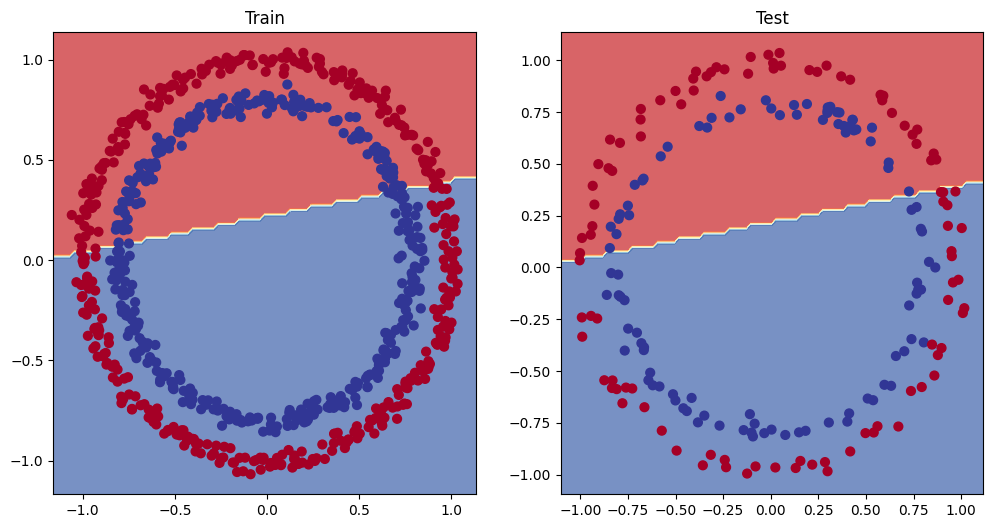

In [16]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

We can now see the cause of our model's poor performance. The decision boundary is a straight line, which means our model is only able to separate the two classes with a linear function.

So how can we improve this?

There are several ways we can fix a model's underfitting problem. This means that we focus on improving the model itself, not the data.

Here are some common ways to improve a model's performance:

- **Increase model complexity**: Add more layers or hidden units to the model.
- **Change activation functions**: Use non-linear activation functions like ReLU or sigmoid instead of linear (hint for later)
- **Fitting for longer**: Train the model for more epochs to allow it to learn more complex patterns.
- **Change the learning rate**: Adjust the learning rate to allow the model to learn more effectively.
- **Change the loss function**: Use a different loss function that is more suitable for the problem.
- **Use transfer learning**: Use a pre-trained model and fine-tune it for the specific problem (this will be covered later).

## Experiment

As a training exercise, try the following:

1. Increase the number of hidden units in the model.
2. Train the model for more epochs.
3. Experiment with different learning rates.
4. Try using a different loss function.

After making these changes, do you see an improvement in the model's performance?

If not, try using this model on [the previous notebook's dataset](03_linear_regression.ipynb) and see if it performs better there.

You should see that the model is working on the previous dataset, in predicting continuous values instead of class labels.

So what is the problem with our current dataset?


## Non-Linearity

We have seen that our model can draw straight lines to separate the two classes, but the data is not linearly separable. This means that we need a model that can handle non-linear relationships.

### Recreate Non-Linear Data


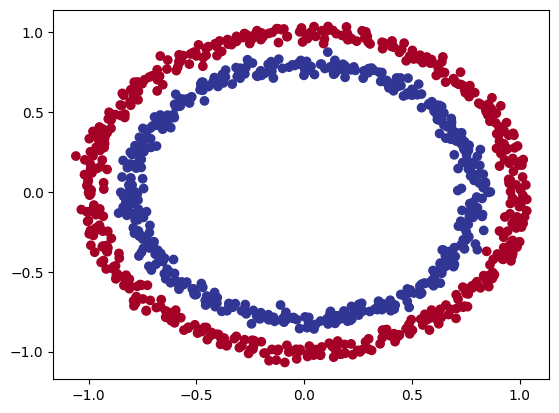

In [17]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [18]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Non-Linear Model

Since ouru data is not linearly separable, we need a model that can handle non-linear relationships. We can do this by adding more layers to our model and using non-linear activation functions.

One of the most common and best performing is [ReLU](<https://en.wikipedia.org/wiki/Rectifier_(neural_networks)>).


In [19]:
from torch import nn


class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

You can go back to the [TensorFlow Playground](https://playground.tensorflow.org/) and try to recreate the non-linear data with a non-linear model.

Now let's create a loss function and optimizer for our non-linear model.


In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### Training a Non-Linear Model


In [21]:
torch.manual_seed(42)

EPOCHS = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
    y_logits = model_1(X_train).squeeze()  # Squeeze to remove extra dimension
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test loss: 0.62145, Test acc: 79.00%


That looks much better! The model is now able to separate the two classes with a non-linear decision boundary.

Let's evaluate the model's performance on the test set to see how well it generalizes to unseen data.

### Evaluate Non-Linear Model


In [22]:
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()

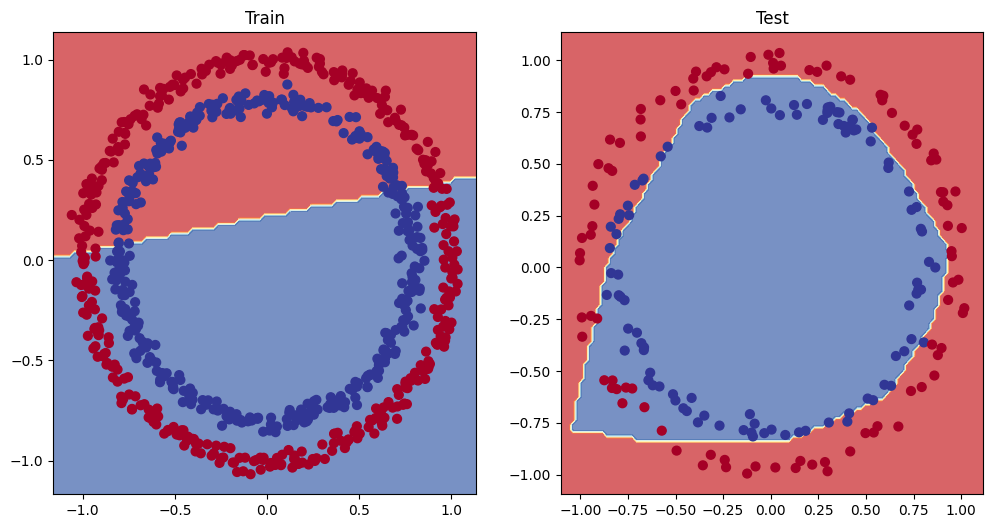

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

The model is still not perfect, but it is much better than the linear model. The decision boundary is now able to separate the two classes with a non-linear function.

As an exercise, try to see how you can improve the model's performance even further. You can try:

- Adding more layers to the model
- Increasing the number of units in each layer
- Experimenting with different activation functions
- Changing the learning rate
- Training for more epochs

I would recommend trying to get the model's accuracy above 90% on the test set. This will require some experimentation and tuning of the hyperparameters.
